In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from lightgbm import LGBMClassifier

# Load the feature-engineered datasets
train = pd.read_csv('../data/train_clean.csv')
test = pd.read_csv('../data/test_clean.csv')

# Check initial shape
print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Separate features and labels
X = train.drop(columns=['Transported'])
y = train['Transported'].astype(int)  # Convert boolean to int for modeling
X_test = test.copy()

# Set up stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Train shape: (8693, 46)
Test shape: (4277, 45)


Version A: Base LightGBM w/ early stopping (logloss)

In [2]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import log_loss, accuracy_score
# from lightgbm import LGBMClassifier, early_stopping, log_evaluation
# import pandas as pd
# import numpy as np

# # Version label
# version_name = 'Version A: Base LGBM (NoAmenities Removed)'

# # Load data
# train = pd.read_csv('../data/train_clean.csv')
# test = pd.read_csv('../data/test_clean.csv')

# # Drop 'NoAmenities' as specified for Version A
# X_full = train.drop(columns=['Transported', 'NoAmenities'])
# y = train['Transported'].astype(int)
# X_test_full = test.drop(columns=['NoAmenities'])

# # Get list of categorical columns
# cat_cols = X_full.select_dtypes(include='object').columns.tolist()
# X_test_full[cat_cols] = X_test_full[cat_cols].astype('category')

# # Set up cross-validation
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# oof_preds = np.zeros(len(X_full))
# test_preds = np.zeros(len(X_test_full))

# # Cross-validation loop
# for fold, (train_idx, val_idx) in enumerate(cv.split(X_full, y)):
#     X_train, y_train = X_full.iloc[train_idx].copy(), y.iloc[train_idx]
#     X_val, y_val = X_full.iloc[val_idx].copy(), y.iloc[val_idx]

#     # Fold-specific categorical columns (safe typing)
#     cat_features = X_train.select_dtypes(include='object').columns.tolist()
#     for col in cat_features:
#         X_train[col] = X_train[col].astype('category')
#         X_val[col] = X_val[col].astype('category')

#     # Align test set columns with training set
#     X_test_fold = X_test_full[X_train.columns]

#     # Define LightGBM model
#     model = LGBMClassifier(
#         learning_rate=0.05,
#         n_estimators=1000,
#         max_depth=6,
#         num_leaves=32,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         random_state=42
#     )

#     # Train with early stopping
#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_val, y_val)],
#         categorical_feature=cat_features,
#         eval_metric='logloss',
#         callbacks=[
#             early_stopping(stopping_rounds=50),
#             log_evaluation(period=0)  # silent
#         ]
#     )

#     # Predict
#     oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
#     test_preds += model.predict_proba(X_test_fold)[:, 1] / cv.n_splits

#     fold_loss = log_loss(y_val, oof_preds[val_idx])
#     print(f'Fold {fold + 1} Log Loss: {fold_loss:.5f}')

# # Final evaluation
# total_loss = log_loss(y, oof_preds)
# accuracy = accuracy_score(y, oof_preds > 0.5)
# print(f'\n{version_name}')
# print(f'Overall CV Log Loss: {total_loss:.5f}')
# print(f'Accuracy: {accuracy:.4f}')

# import matplotlib.pyplot as plt
# import lightgbm as lgb

# lgb.plot_importance(model, max_num_features=20, importance_type='gain')
# plt.title("VA - Feature Importance (gain)")
# plt.show()

Version B: NoAmenities Only

In [3]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import log_loss, accuracy_score
# from lightgbm import LGBMClassifier, early_stopping, log_evaluation
# import pandas as pd
# import numpy as np

# # Version label
# version_name = 'Version B: LGBM with NoAmenities Only'

# # Load data
# train = pd.read_csv('../data/train_clean.csv')
# test = pd.read_csv('../data/test_clean.csv')

# # Drop the 5 individual spend features
# drop_spend = ['TotalSpend','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
# X_full = train.drop(columns=['Transported'] + drop_spend)
# y = train['Transported'].astype(int)
# X_test_full = test.drop(columns=drop_spend)

# # Ensure NoAmenities is kept
# assert 'NoAmenities' in X_full.columns

# # Get categorical columns
# cat_cols = X_full.select_dtypes(include='object').columns.tolist()
# X_test_full[cat_cols] = X_test_full[cat_cols].astype('category')

# # Set up cross-validation
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# oof_preds = np.zeros(len(X_full))
# test_preds = np.zeros(len(X_test_full))

# # Cross-validation loop
# for fold, (train_idx, val_idx) in enumerate(cv.split(X_full, y)):
#     X_train, y_train = X_full.iloc[train_idx].copy(), y.iloc[train_idx]
#     X_val, y_val = X_full.iloc[val_idx].copy(), y.iloc[val_idx]

#     # Categorical casting per fold
#     cat_features = X_train.select_dtypes(include='object').columns.tolist()
#     for col in cat_features:
#         X_train[col] = X_train[col].astype('category')
#         X_val[col] = X_val[col].astype('category')

#     X_test_fold = X_test_full[X_train.columns]

#     # Model
#     model = LGBMClassifier(
#         learning_rate=0.05,
#         n_estimators=1000,
#         max_depth=6,
#         num_leaves=32,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         random_state=42
#     )

#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_val, y_val)],
#         categorical_feature=cat_features,
#         eval_metric='logloss',
#         callbacks=[
#             early_stopping(stopping_rounds=50),
#             log_evaluation(period=0)
#         ]
#     )

#     oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
#     test_preds += model.predict_proba(X_test_fold)[:, 1] / cv.n_splits

#     fold_loss = log_loss(y_val, oof_preds[val_idx])
#     print(f'Fold {fold + 1} Log Loss: {fold_loss:.5f}')

# # Final evaluation
# total_loss = log_loss(y, oof_preds)
# accuracy = accuracy_score(y, oof_preds > 0.5)
# print(f'\n{version_name}')
# print(f'Overall CV Log Loss: {total_loss:.5f}')
# print(f'Accuracy: {accuracy:.4f}')

# import matplotlib.pyplot as plt
# import lightgbm as lgb

# lgb.plot_importance(model, max_num_features=20, importance_type='gain')
# plt.title("VB - Feature Importance (gain)")
# plt.show()


Verson C: No changes

In [4]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import log_loss, accuracy_score
# from lightgbm import LGBMClassifier, early_stopping, log_evaluation
# import pandas as pd
# import numpy as np

# # Load data
# train = pd.read_csv('../data/train_clean.csv')
# test = pd.read_csv('../data/test_clean.csv')

# # Separate features and target
# X_full = train.drop(columns=['Transported'])
# y = train['Transported'].astype(int)
# X_test_full = test.copy()

# # Get categorical columns once from full training set (non-leaky)
# cat_cols = X_full.select_dtypes(include='object').columns.tolist()
# X_test_full[cat_cols] = X_test_full[cat_cols].astype('category')  # Pre-convert test set

# # Setup CV
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Store predictions
# oof_preds = np.zeros(len(X_full))
# test_preds = np.zeros(len(X_test_full))

# # Loop over folds
# for fold, (train_idx, val_idx) in enumerate(cv.split(X_full, y)):
#     X_train = X_full.iloc[train_idx].copy()
#     y_train = y.iloc[train_idx]
#     X_val = X_full.iloc[val_idx].copy()
#     y_val = y.iloc[val_idx]

#     # Get categorical columns from training fold (ensures no leakage)
#     cat_features = X_train.select_dtypes(include='object').columns.tolist()

#     # Convert to category dtype for LightGBM
#     for col in cat_features:
#         X_train[col] = X_train[col].astype('category')
#         X_val[col] = X_val[col].astype('category')

#     # Ensure column alignment
#     X_test_fold = X_test_full[X_train.columns]

#     # Initialize and train model
#     model = LGBMClassifier(
#         learning_rate=0.05,
#         n_estimators=1000,
#         max_depth=6,
#         num_leaves=32,
#         subsample=0.8,
#         colsample_bytree=0.8,
#         random_state=42
#     )

#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_val, y_val)],
#         categorical_feature=cat_features,
#         eval_metric='logloss',
#         callbacks=[
#             early_stopping(stopping_rounds=50),
#             log_evaluation(period=0)  # silence output
#         ]
#     )

#     # Predict on validation and test
#     oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
#     test_preds += model.predict_proba(X_test_fold)[:, 1] / cv.n_splits

#     # Log fold loss
#     fold_loss = log_loss(y_val, oof_preds[val_idx])
#     print(f'Fold {fold + 1} Log Loss: {fold_loss:.5f}')

# # Final evaluation
# total_loss = log_loss(y, oof_preds)
# accuracy = accuracy_score(y, oof_preds > 0.5)
# print(f'\nOverall CV Log Loss: {total_loss:.5f}')
# print(f'Accuracy: {accuracy:.4f}')

# import matplotlib.pyplot as plt
# import lightgbm as lgb

# lgb.plot_importance(model, max_num_features=20, importance_type='gain')
# plt.title("VC - Feature Importance (gain)")
# plt.show()

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4431
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

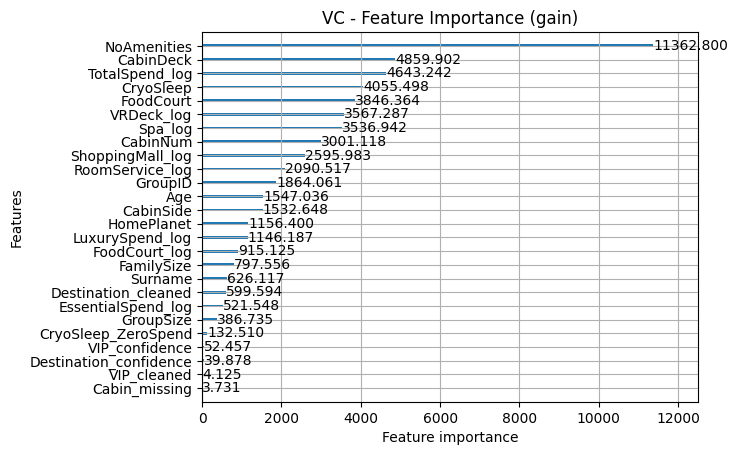

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import pandas as pd
import numpy as np

# Load data
train = pd.read_csv('../data/train_clean.csv')
test = pd.read_csv('../data/test_clean.csv')

# Separate features and target
X_full = train.drop(columns=['Transported'])
y = train['Transported'].astype(int)
X_test_full = test.copy()

# Drop raw spends if logs are better (test this)
drop_raw_spends = ['RoomService', 'FoodService', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpend', 'LuxurySpend', 'EssentialSpend']
X_full = X_full.drop(columns=drop_raw_spends, errors='ignore')
X_test_full = X_test_full.drop(columns=drop_raw_spends, errors='ignore')

# Get categorical columns once from full training set (non-leaky)
cat_cols = X_full.select_dtypes(include='object').columns.tolist()
X_test_full[cat_cols] = X_test_full[cat_cols].astype('category')  # Pre-convert test set

# Setup CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store predictions
oof_preds = np.zeros(len(X_full))
test_preds = np.zeros(len(X_test_full))

# Loop over folds
for fold, (train_idx, val_idx) in enumerate(cv.split(X_full, y)):
    X_train = X_full.iloc[train_idx].copy()
    y_train = y.iloc[train_idx]
    X_val = X_full.iloc[val_idx].copy()
    y_val = y.iloc[val_idx]

    # Get categorical columns from training fold (ensures no leakage)
    cat_features = X_train.select_dtypes(include='object').columns.tolist()

    # Convert to category dtype for LightGBM
    for col in cat_features:
        X_train[col] = X_train[col].astype('category')
        X_val[col] = X_val[col].astype('category')

    # Ensure column alignment
    X_test_fold = X_test_full[X_train.columns]

    # Initialize and train model
    model = LGBMClassifier(
        learning_rate=0.05,
        n_estimators=1000,
        max_depth=6,
        num_leaves=32,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        categorical_feature=cat_features,
        eval_metric='logloss',
        callbacks=[
            early_stopping(stopping_rounds=50),
            log_evaluation(period=0)  # silence output
        ]
    )

    # Predict on validation and test
    oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
    test_preds += model.predict_proba(X_test_fold)[:, 1] / cv.n_splits

    # Log fold loss
    fold_loss = log_loss(y_val, oof_preds[val_idx])
    print(f'Fold {fold + 1} Log Loss: {fold_loss:.5f}')

# Final evaluation
total_loss = log_loss(y, oof_preds)
accuracy = accuracy_score(y, oof_preds > 0.5)
print(f'\nOverall CV Log Loss: {total_loss:.5f}')
print(f'Accuracy: {accuracy:.4f}')

import matplotlib.pyplot as plt
import lightgbm as lgb

lgb.plot_importance(model, max_num_features=30, importance_type='gain')
plt.title("VC - Feature Importance (gain)")
plt.show()

# Save submission
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Transported': (test_preds > 0.5).astype(bool)
})
submission.to_csv('../submissions/lgbm_submission.csv', index=False)

In [6]:
train_groups = set(train['GroupID'].unique())
test_groups = set(test['GroupID'].unique())
overlaps = train_groups.intersection(test_groups)
print(f"Number of overlapping GroupIDs: {len(overlaps)}")  # Should be 0

Number of overlapping GroupIDs: 0
